# Bayesian Stochastic Volatility Model


## pymc3_bayes_stochastic_vol.py

### Import Packages
The first task is to import the necessary libraries used in the stochastic volatility model. This consists of NumPy, SciPy, Pandas, Matplotlib and Seaborn. These libraries are used for data import, manipulation and plotting.

As in previous chapters the PyMC3 library is used to carry out the MCMC procedure. The GaussianRandomWalk model is imported and is used to model the returns of the daily equity prices:

In [4]:
import datetime 
import pprint

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pandas_datareader as pdr 
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk 
import seaborn as sns

### 6.3.1 Obtaining the Price History

The returns of Amazon, Inc. (AMZN) are downloaded from Yahoo Finance using the pandas_datareader module. However, it is straightforward to utilise S&P500, FTSE100 or any other asset pricing
data.

Pandas is used to obtain the raw pricing information and convert it into a returns stream suitable for analysis with the stochastic vol model. This is achieved by taking the ratio of the current days adjusted close to the previous days adjusted close. These percentage returns values are then transformed with the natural logarithm function to produce the log returns.

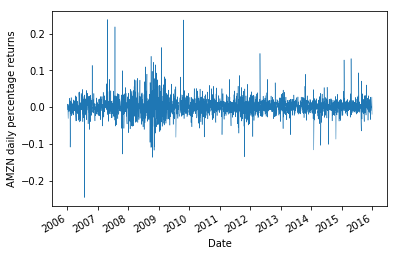

In [13]:
"""
Download, calculate and plot the AMZN logarithmic returns.
"""
def obtain_plot_amazon_prices_dataframe(start_date, end_date): 
    print("Downloading and plotting AMZN log returns...")
    amzn = pdr.get_data_yahoo("AMZN", start_date, end_date) 
    amzn["returns"] = amzn["Adj Close"]/amzn["Adj Close"].shift(1) 
    amzn.dropna(inplace=True)
    amzn["log_returns"] = np.log(amzn["returns"]) 
    amzn["log_returns"].plot(linewidth=0.5) 
    plt.ylabel("AMZN daily percentage returns") 
    plt.show()
    return amzn

start_date = datetime.datetime(2006, 1, 1)
end_date = datetime.datetime(2015, 12, 31)
amzn_df_temp = obtain_plot_amazon_prices_dataframe(start_date, end_date)
#amzn_df_temp # print Data


### 6.3.2 Model Specification in PyMC3

Now that the returns have been calculated attention will turn towards specifying the Bayesian model via the priors described above. As in previous chapters the model is instantiated via the pm.Model() syntax in a with context. Each prior is then defined as above:

It remains to sample the model with the No-U-Turn Sampler MCMC procedure.

In [29]:
### 6.3.2 Model Specification in PyMC3
"""
Configure the stochastic volatility model using PyMC3 in a ’with’ context. 

Then sample from the model using the No-U-Turn-Sampler (NUTS).

Plot the logarithmic volatility process and then the absolute returns 
    overlaid with the estimated vol.
"""
def configure_sample_stoch_vol_model(log_returns, samples): 

    print("Configuring stochastic volatility with PyMC3...") 
    model = pm.Model() # define the model
    with model:
        sigma = pm.Exponential('sigma', 50.0, testval=0.1) # define dist of Sigma
        nu = pm.Exponential('nu', 0.1) # define dist of Nu, the change in volatility
        s = GaussianRandomWalk('s', sigma**-2, shape=len(log_returns)) # define the deist of Volatility
        logrets = pm.StudentT( # define log return dist as the student t-dist
            'logrets', nu,
            lam=pm.math.exp(-2.0*s),
            observed=log_returns
        )
        
    ### 6.3.3 Fitting the Model with NUTS
    print("Fitting the stochastic volatility model...") 
    with model:
        trace = pm.sample(samples)
    pm.traceplot(trace, model.vars[:-1])
    plt.show()
    
    ### Plotting the log volatility
    print("Plotting the log volatility...")
    k = 10
    opacity = 0.03
    plt.plot(trace[s][::k].T, 'b', alpha=opacity)
    plt.xlabel('Time')
    plt.ylabel('Log Volatility')
    plt.show()
    
    print("Plotting the absolute returns overlaid with vol...") 
    plt.plot(np.abs(np.exp(log_returns))-1.0, linewidth=0.5) 
    plt.plot(np.exp(trace[s][::k].T), 'r', alpha=opacity) 
    plt.xlabel("Trading Days")
    plt.ylabel("Absolute Returns/Volatility")
    plt.show()




### 6.3.3 Fitting the Model with NUTS

Now that the model has been specified it is possible to run the NUTS MCMC sampler and generate a traceplot in a similar manner to that carried out in the previous chapter on Bayesian Linear Regression. Thankfully PyMC3 abstracts much of the implementation details of NUTS away from us, allowing us to concentrate on the important procedure of model specification.

For this example 2000 samples are used in the NUTS sampler. Note that this will take some time to calculate. It took 15-20 minutes on my desktop PC to produce the plots below. The API for sampling is very straightforward. Under a with context the model simply utilises the pm.sample method to produce a trace object that can later be used for visualisation of marginal parameter distributions and the sample trace itself:


### Plotting the log volatility

Another useful plot is that of the estimated volatility of AMZN against the trading days. To achieve such a plot it is possible to take every kth sample, for each trading day of the volatility distribution and overlay them semi-opaquely.

### Main
This code is then subsequently wrapped up in a __main__ function call, the full code of which is provided in the following section.


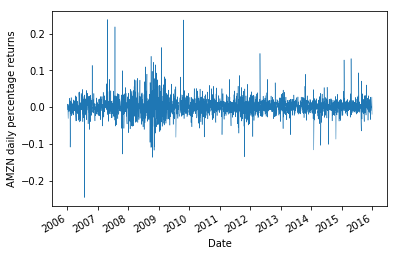

Configuring stochastic volatility with PyMC3...


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting the stochastic volatility model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, nu, sigma]
Sampling 4 chains: 100%|██████████| 2040/2040 [02:10<00:00,  3.27draws/s]
/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


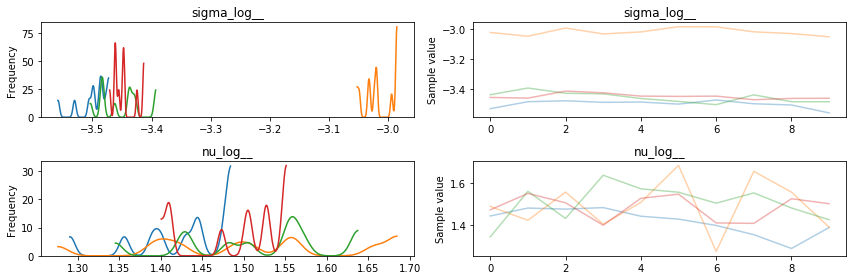

Plotting the log volatility...


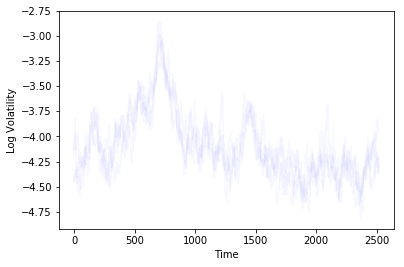

Plotting the absolute returns overlaid with vol...


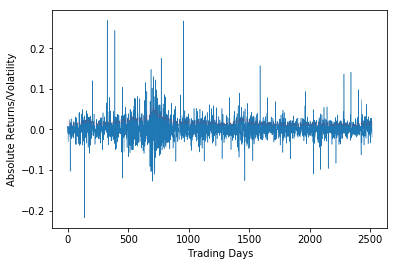

In [30]:
if __name__ == "__main__":
    # State the starting and ending dates of the AMZN returns 
    start_date = datetime.datetime(2006, 1, 1)
    end_date = datetime.datetime(2015, 12, 31)
   
    # Obtain and plot the logarithmic returns of Amazon prices
    amzn_df = obtain_plot_amazon_prices_dataframe(start_date, end_date) 
    log_returns = np.array(amzn_df["log_returns"])
    
    # Configure the stochastic volatility model and carry out 
    # MCMC sampling using NUTS, plotting the trace
    samples = 10#2000 
    configure_sample_stoch_vol_model(log_returns, samples)
    
    
    